<a href="https://colab.research.google.com/github/nickintj/20242R0136COSE47402/blob/main/Final%20Project/Hyper_CLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from torchvision.datasets import CIFAR100
import torchvision.transforms as transforms
import numpy as np

# Data transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 for CLIP
    transforms.ToTensor()
])

# Load dataset
train_data = CIFAR100(root='./data', train=True, download=True, transform=transform)
test_data = CIFAR100(root='./data', train=False, download=True, transform=transform)

coarse_label_mapping = np.array([ 4,  1, 14,  8,  0,  6,  7,  7, 18,  3,
                               3, 14,  9, 18,  7, 11,  3,  9,  7, 11,
                               6, 11,  5, 10,  7,  6, 13, 15,  3, 15,
                               0, 11,  1, 10, 12, 14, 16,  9, 11,  5,
                               5, 18,  8,  8, 15, 13, 14, 17, 18, 10,
                               16, 4, 17,  4,  2,  0, 17,  4, 18, 17,
                               10, 3,  2, 12, 12, 16, 12,  1,  9, 18,
                               2, 10,  0,  1, 16, 12,  9, 13, 15, 13,
                              16, 18,  2,  4,  6, 18,  5,  5,  8, 18,
                              18,  1,  2, 15,  6,  0, 17,  8, 14, 13])

train_data.targets = [coarse_label_mapping[label] for label in train_data.targets]
test_data.targets = [coarse_label_mapping[label] for label in test_data.targets]

100%|██████████| 169M/169M [00:05<00:00, 30.6MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [2]:
import torch
from transformers import CLIPProcessor, CLIPModel

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Freeze pre-trained layers if required
for name, param in model.named_parameters():
    if 'vision_model' in name:
        param.requires_grad = True


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [3]:
from torch import nn

# Modify the image tower for classification
num_classes = 19

#model.classification_head = nn.Linear(model.vision_model.config.hidden_size, num_classes)
model.vision_model.head = nn.Linear(model.vision_model.config.hidden_size, num_classes)

assert all(0 <= label < 19 for label in train_data.targets), "Train labels are out of bounds."
assert all(0 <= label < 19 for label in test_data.targets), "Test labels are out of bounds."

In [4]:
coarse_class_texts=[
    'aquatic_mammals', 'fish', 'flowers', 'food_containers',
    'fruit_and_vegetables', 'household_electrical_devices',
    'household_furniture', 'insects', 'large_carnivores',
    'large_man-made_outdoor_things', 'large_natural_outdoor_scenes',
    'large_omnivores_and_herbivores', 'medium_mammals',
    'non-insect_invertebrates', 'people', 'reptiles', 'small_mammals',
    'trees', 'vehicles'
]

In [8]:
from torch import nn, optim
from tqdm import tqdm
from torch.utils.data import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"

# Set the model to train mode
model.train()

# Define an optimiser
optimizer = optim.Adam(model.parameters(), lr=3e-4)

# Loss function
loss_fn = nn.CrossEntropyLoss()
epochs = 5
train_loader = DataLoader(train_data, batch_size=50, shuffle=True)
# Training loop
for epoch in range(epochs):
    for images, labels in tqdm(train_loader):
        optimizer.zero_grad()

        # Process images and text
        inputs_image = processor(images=images, return_tensors="pt").to(device)
        text_inputs = processor(text=coarse_class_texts, return_tensors="pt", padding=True).to(device)

        # Forward pass through the model
        outputs = model(**inputs_image, input_ids=text_inputs.input_ids)

        # Calculate loss
        logits_per_image = outputs.logits_per_image.to(device)
        logits_per_text = outputs.logits_per_text.to(device)

        # Compute contrastive loss
        loss = loss_fn(logits_per_image, labels.to(device))  # or use a custom contrastive loss function

        # Backpropagation
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}")


100%|██████████| 1000/1000 [08:11<00:00,  2.04it/s]


Epoch 1/5, Loss: 2.927072763442993


100%|██████████| 1000/1000 [08:07<00:00,  2.05it/s]


Epoch 2/5, Loss: 2.925762414932251


100%|██████████| 1000/1000 [08:07<00:00,  2.05it/s]


Epoch 3/5, Loss: 2.9132637977600098


100%|██████████| 1000/1000 [08:08<00:00,  2.05it/s]


Epoch 4/5, Loss: 2.8803963661193848


100%|██████████| 1000/1000 [08:07<00:00,  2.05it/s]


Epoch 5/5, Loss: 2.915745496749878


In [10]:
from tqdm import tqdm
model.eval()

correct = 0
total = 0
test_loader = DataLoader(test_data, batch_size=50, shuffle=False)
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        inputs_image = processor(images=images, return_tensors="pt").to(device)
        text_inputs = processor(text=coarse_class_texts, return_tensors="pt", padding=True).to(device)

        # Get model predictions
        outputs = model(**inputs_image, input_ids=text_inputs.input_ids)

        logits_per_image = outputs.logits_per_image.to(device)
        predicted = logits_per_image.argmax(dim=-1)

        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

100%|██████████| 200/200 [01:23<00:00,  2.41it/s]

Test Accuracy: 10.00%


In [6]:
original_test_data = CIFAR100(root='./data', train=False, download=True, transform=transform)

original_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
original_model.vision_model.head = nn.Linear(original_model.vision_model.config.hidden_size, 100)

Files already downloaded and verified


In [14]:
from tqdm import tqdm
model.eval()
original_model.eval()

correct = 0
total = 0
test_loader = DataLoader(original_test_data, batch_size=50, shuffle=False)

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        inputs_image = processor(images=images, return_tensors="pt").to(device)
        text_inputs = processor(text=original_test_data.classes, return_tensors="pt", padding=True).to(device)

        # Get model predictions
        outputs = model(**inputs_image, input_ids=text_inputs.input_ids)

        logits_per_image = outputs.logits_per_image.to(device)
        predicted = logits_per_image.argmax(dim=-1)

        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

correct = 0
total = 0
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        inputs_image = processor(images=images, return_tensors="pt").to(device)
        text_inputs = processor(text=original_test_data.classes, return_tensors="pt", padding=True).to(device)

        # Get model predictions
        outputs = original_model(**inputs_image, input_ids=text_inputs.input_ids)

        logits_per_image = outputs.logits_per_image.to(device)
        predicted = logits_per_image.argmax(dim=-1)

        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

original_accuracy = 100 * correct / total
print(f"Test Accuracy: {original_accuracy:.2f}%")

100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


Test Accuracy: 1.00%


100%|██████████| 200/200 [01:24<00:00,  2.36it/s]

Test Accuracy: 1.00%


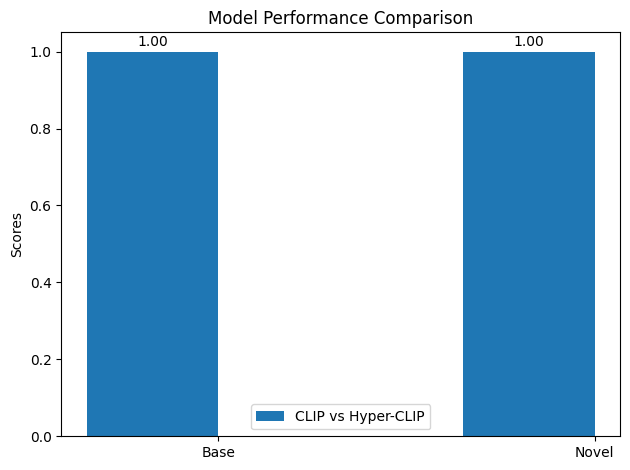

In [15]:
# Visualisation

import matplotlib.pyplot as plt
import numpy as np

metrics = ['Base', 'Novel']

acc_list = [accuracy, original_accuracy]

bar_width = 0.35
index = np.arange(len(metrics))
fig, ax = plt.subplots()
bar1 = ax.bar(index, acc_list, bar_width, label='CLIP vs Hyper-CLIP')

ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(metrics)
ax.legend()

def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 2),  # 2 points vertical offset
                    textcoords='offset points',
                    ha='center', va='bottom')

add_value_labels(bar1)
plt.tight_layout()
plt.show()
